In [38]:
%matplotlib inline

import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import IPython

import sys

sys.path.append('.')

from niveau_nappe_core import *

sns.set()

In [39]:
sources = pd.read_csv('../data_collection/dataset_stations.csv', delimiter=',', index_col=0)
sources.head()

,bss,x,y,geometry,dpt,prof,alt,masse_eau,codes_bdlisa,CodeEH,InclusEH,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH
0,10402X0177/JOURDA,3.387383,43.336667,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",34,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,09654X0569/CNRP20,4.607080,43.848274,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",30,18.0,12.0,"[""Alluvions du RhÃ´ne du confluent de la Duran...",712AJ05,712AJ05,712AJ,2,5.0,1,1.0,1.0
2,02581X0104/P18,2.543903,48.523357,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",77,34.0,60.0,NaN,113AA01,113AA01,113AA,3,5.0,5,2.0,1.0
3,02913X0024/P,1.640479,48.401585,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",28,12.0,153.4,['Multicouches craie du SÃ©no-turonien et calc...,107AA01,107AA01,107AA,3,5.0,5,2.0,1.0
4,00182X0031/P,2.258327,50.544651,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",62,62.8,180.0,"[""Craie de l'Artois et de la vallÃ©e de la Lys""]",121BD01,121BD01,121BD,3,5.0,4,2.0,1.0


In [40]:
all_data = pd.read_csv('../data_collection/dataset_2015_2021.csv', delimiter=',', index_col=0, parse_dates=['time'])
all_data.head()

,time,tp,e,p
bss,,,,
00035X0029/P1,2015-01-01,4.032627e-07,-0.007191,NaN
00035X0029/P1,2015-01-02,4.143920e-04,-0.007938,NaN
00035X0029/P1,2015-01-03,1.245819e-02,-0.005537,NaN
00035X0029/P1,2015-01-04,8.401461e-06,-0.005635,NaN
00035X0029/P1,2015-01-05,3.353972e-05,-0.002760,2.12


In [49]:
piezo_without_data = set(sources.bss).difference(all_data.index)
print(len(piezo_without_data), 'over', sources.shape[0], 'Piezometers without data')

146 over 2810 Piezometers without data


In [4]:
print(all_data.shape)

(6385618, 4)


In [5]:
all_data.describe()

,tp,e,p
count,6.385618e+06,6.154903e+06,5.609789e+06
mean,2.369712e-03,-2.209840e-02,2.386367e+01
std,4.776088e-03,1.514301e-02,9.170191e+01
min,-2.235174e-08,-1.425720e-01,-3.215950e+03
25%,1.012348e-06,-3.286862e-02,3.390000e+00
50%,2.906323e-04,-1.967973e-02,8.480000e+00
75%,2.566085e-03,-9.407496e-03,2.277000e+01
max,1.504297e-01,1.339646e-02,1.002040e+04


In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6385618 entries, 00035X0029/P1 to BSS003ZKDU/X
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   tp      float64       
 2   e       float64       
 3   p       float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 243.6+ MB


In [7]:
code_bss = "00471X0095/PZ2013"
bss_id = "BSS000EBLL"

data = all_data.loc[code_bss].set_index('time')
data = data.sort_index()

data.head()

,tp,e,p
time,,,
2015-01-01,0.000002,-0.002716,11.65
2015-01-02,0.000968,-0.006637,11.61
2015-01-03,0.009156,-0.001883,11.56
2015-01-04,0.000030,-0.003922,11.53
2015-01-05,0.000032,-0.001558,11.49


In [8]:
data.describe()

,tp,e,p
count,2.397000e+03,2313.000000,2396.000000
mean,2.104166e-03,-0.019895,11.799587
std,3.560893e-03,0.013659,2.503397
min,-2.235174e-08,-0.063269,5.850000
25%,1.803786e-05,-0.029545,9.810000
50%,4.635220e-04,-0.017830,12.315000
75%,2.717312e-03,-0.008171,13.780000
max,2.918985e-02,0.004677,15.950000


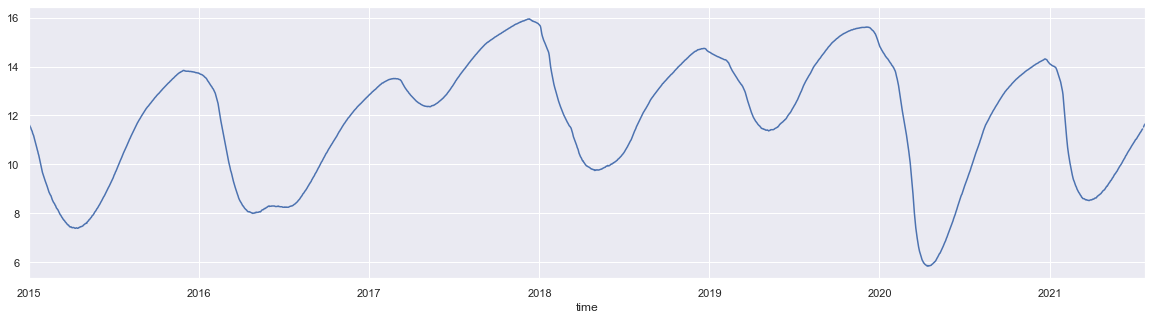

In [9]:
ax = data.p.plot(figsize=(20, 5))
ax.get_figure().savefig(f'Images/piezometre_{bss_id}.png')

<AxesSubplot:xlabel='time'>

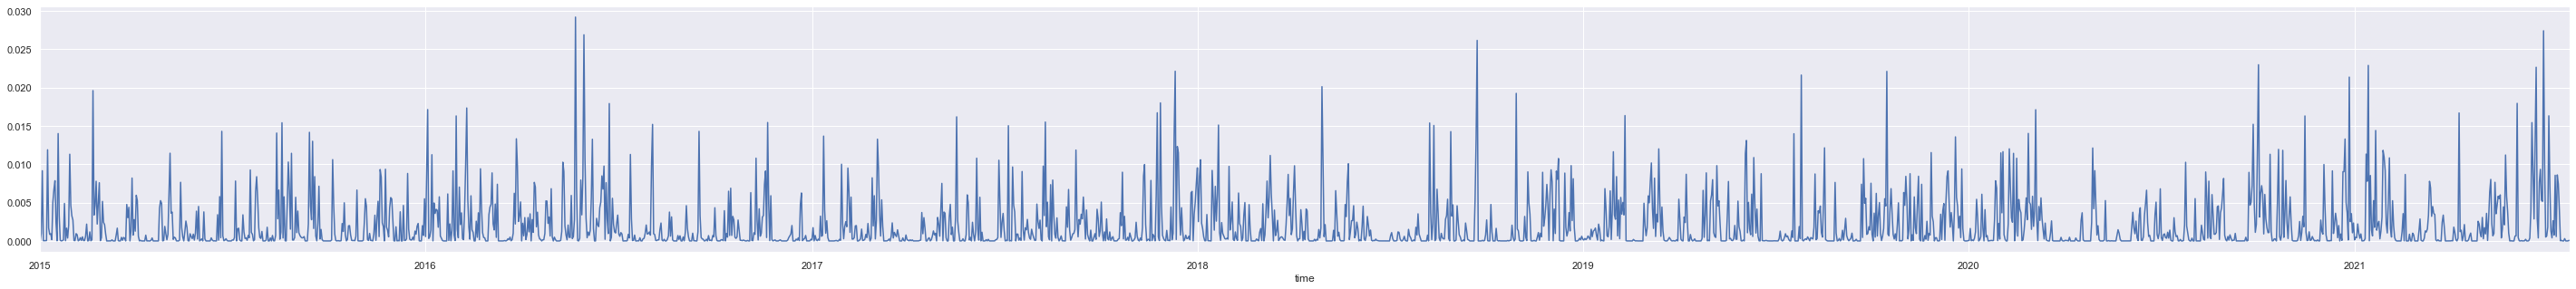

In [10]:
data.tp.plot(figsize=(50, 5))

<AxesSubplot:xlabel='time'>

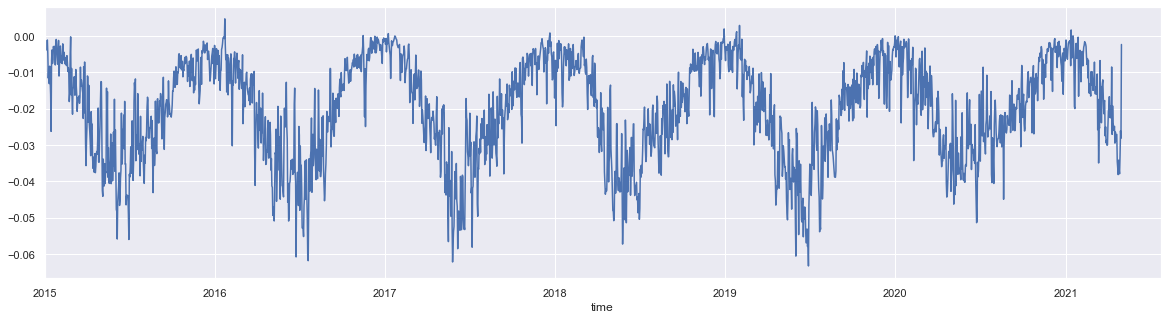

In [11]:
data.e.plot(figsize=(20, 5))

<AxesSubplot:>

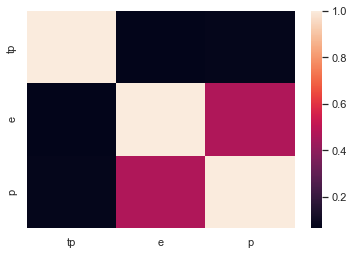

In [12]:
sns.heatmap(data.corr())

# Preprocessing

## Resampling the data to have a measure per day

In [13]:
data.index.to_series().diff()

time
2015-01-01      NaT
2015-01-02   1 days
2015-01-03   1 days
2015-01-04   1 days
2015-01-05   1 days
              ...  
2021-07-20   1 days
2021-07-21   1 days
2021-07-22   1 days
2021-07-23   1 days
2021-07-24   1 days
Name: time, Length: 2397, dtype: timedelta64[ns]

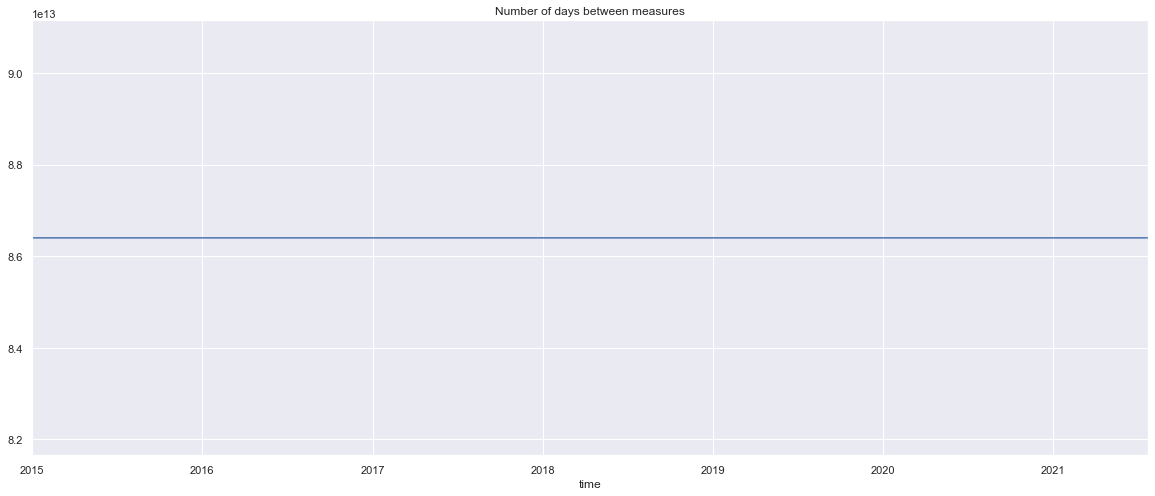

In [14]:
ax = data.index.to_series().diff().plot(figsize=(20, 8), title='Number of days between measures')
ax.get_figure().savefig(f'Images/intervalle_inter_messure_{bss_id}.png')

There are a lot of missing values before the year 2000. We are going to start at 01 Jan 2000

In [15]:
# select depth col
data = data[['p']]

# dropna
data = data.dropna()
data.head()

,p
time,
2015-01-01,11.65
2015-01-02,11.61
2015-01-03,11.56
2015-01-04,11.53
2015-01-05,11.49


In [16]:
# start_date = '04-05-1970'
# start_date = '09-08-1984'
# start_date = '01-01-2000'
start_date = data.index.min()

data = data.loc[start_date:, :]

new_index = pd.date_range(start_date, data.index.max())

missing_index = new_index.difference(data.index)

print("There are", missing_index.size, "missing dates over ", new_index.size, " => ", round(100 * missing_index.size/new_index.size, 2), "% of data")

There are 1 missing dates over  2397  =>  0.04 % of data


In [17]:
# date feature
data = add_date_features(data)
data.head()

,p,year,month,quarter,weekday,day
time,,,,,,
2015-01-01,11.65,2015,1,1,3,1
2015-01-02,11.61,2015,1,1,4,2
2015-01-03,11.56,2015,1,1,5,3
2015-01-04,11.53,2015,1,1,6,4
2015-01-05,11.49,2015,1,1,0,5


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF, ExpSineSquared

def build_imputer_model():
    
    kernel = Matern()

    scaler = StandardScaler()

    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

    gp = Pipeline([('sc', scaler), ('gpr', gpr)])

    return gp

In [19]:
imputer = build_imputer_model()

imputer.fit(data[['year', 'month', 'quarter', 'weekday', 'day']], data['p'])

print('Score:', imputer.score(data[['year', 'month', 'quarter', 'weekday', 'day']], data['p']))

Score: 1.0


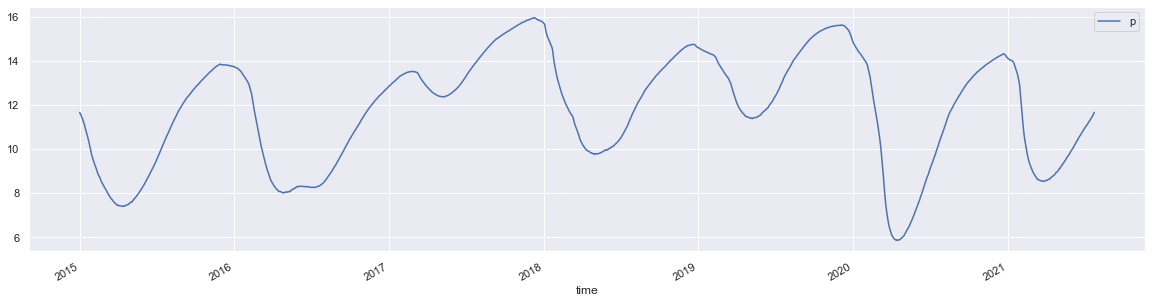

In [20]:
data[['p']].plot(label='with missing', figsize=(20, 5))
plt.show()

In [21]:
missing_X = np.concatenate([missing_index.year.values.reshape((-1, 1)), 
                             missing_index.month.values.reshape((-1, 1)), 
                             missing_index.quarter.values.reshape((-1, 1)), 
                             missing_index.weekday.values.reshape((-1, 1)), 
                             missing_index.day.values.reshape((-1, 1))], axis=1)
missing_X
missing_y = imputer.predict(missing_X)

In [22]:
missing_X.shape, missing_y.shape

((1, 5), (1,))

In [23]:
cols = ['year', 'month', 'quarter', 'weekday', 'day', 'p']
missing_X_y = pd.DataFrame(data=np.concatenate([missing_X, np.expand_dims(missing_y, axis=1)], axis=1), 
                           columns=cols, 
                           index=missing_index)

data_no_missing = data[cols].append(missing_X_y)
data_no_missing = data_no_missing.loc[new_index].sort_index()
data_no_missing

,year,month,quarter,weekday,day,p
2015-01-01,2015.0,1.0,1.0,3.0,1.0,11.650000
2015-01-02,2015.0,1.0,1.0,4.0,2.0,11.610000
2015-01-03,2015.0,1.0,1.0,5.0,3.0,11.560000
2015-01-04,2015.0,1.0,1.0,6.0,4.0,11.530000
2015-01-05,2015.0,1.0,1.0,0.0,5.0,11.490000
...,...,...,...,...,...,...
2021-07-20,2021.0,7.0,3.0,1.0,20.0,10.985126
2021-07-21,2021.0,7.0,3.0,2.0,21.0,11.530000
2021-07-22,2021.0,7.0,3.0,3.0,22.0,11.580000
2021-07-23,2021.0,7.0,3.0,4.0,23.0,11.620000


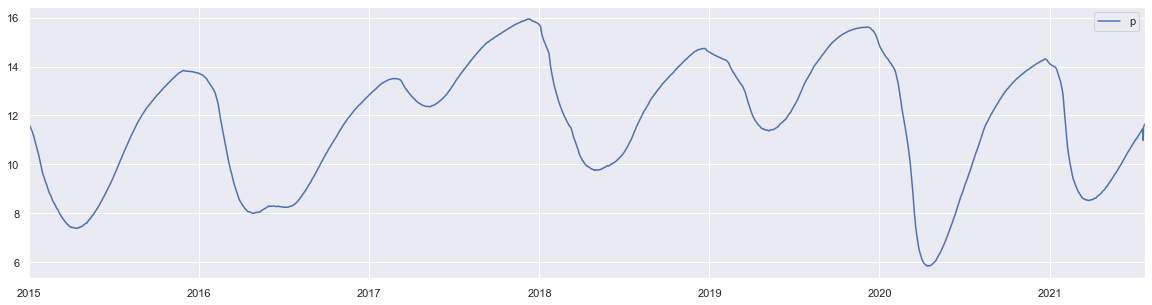

In [24]:
data_no_missing[['p']].plot(label='without missing', figsize=(20, 5))
plt.show()

### Feature engineering

- Extract day features: day of week, month, day of month
- Add temperature
- Add precipitation

In [25]:
# First and second degree diff
data_no_missing = add_derivate_features(data_no_missing, 'p')

data_no_missing.tail()

,year,month,quarter,weekday,day,p,diff_p,diff30_p,diff90_p,diff180_p,diff_diff_p
2021-07-20,2021.0,7.0,3.0,1.0,20.0,10.985126,-0.464874,0.405126,2.165126,-2.574874,-0.484874
2021-07-21,2021.0,7.0,3.0,2.0,21.0,11.530000,0.544874,0.920000,2.680000,-1.970000,1.009749
2021-07-22,2021.0,7.0,3.0,3.0,22.0,11.580000,0.050000,0.940000,2.710000,-1.860000,-0.494874
2021-07-23,2021.0,7.0,3.0,4.0,23.0,11.620000,0.040000,0.950000,2.720000,-1.750000,-0.010000
2021-07-24,2021.0,7.0,3.0,5.0,24.0,11.650000,0.030000,0.940000,2.730000,-1.630000,-0.010000


### Split dataset 

$70\%$ for training, $20\%$ for validation and $10\%$ for test

In [26]:
features = ['p', 'year', 'month', 'quarter', 'weekday', 'day', 'diff_p', 'diff30_p', 'diff90_p', 'diff180_p', 'diff_diff_p']

df = data_no_missing[features]

n_features = len(features)

n = df.shape[0]

len_train = int(n * 0.7)
len_val = int(n * 0.2)

train_df = df[:len_train]
val_df = df[len_train:len_train+len_val]
test_df = df[len_train+len_val:]

print('Train shape:', train_df.shape)
print('Val shape:', val_df.shape)
print('Test shape:', test_df.shape)
print('Number of observations:', n) 
print('Features:', features, 'number:', n_features)

Train shape: (1677, 11)
Val shape: (479, 11)
Test shape: (241, 11)
Number of observations: 2397
Features: ['p', 'year', 'month', 'quarter', 'weekday', 'day', 'diff_p', 'diff30_p', 'diff90_p', 'diff180_p', 'diff_diff_p'] number: 11


## Data normalization

To do when working with more than one feature

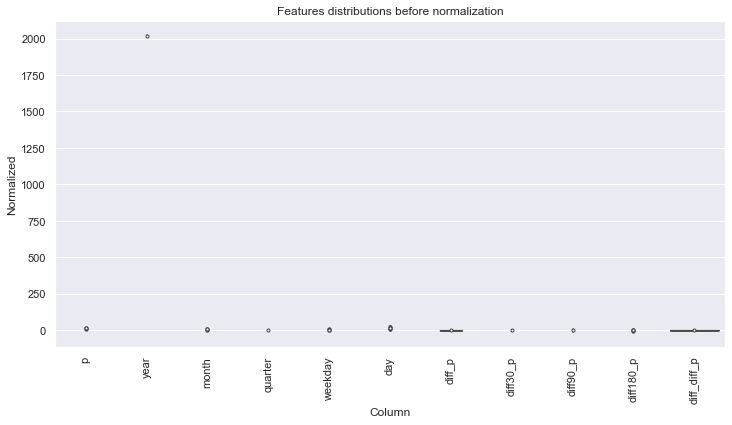

In [27]:
df_tmp = df.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_tmp)
ax.set_xticklabels(df.keys(), rotation=90)
#ax.set_yscale('log')
ax.set_title('Features distributions before normalization');

In [28]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

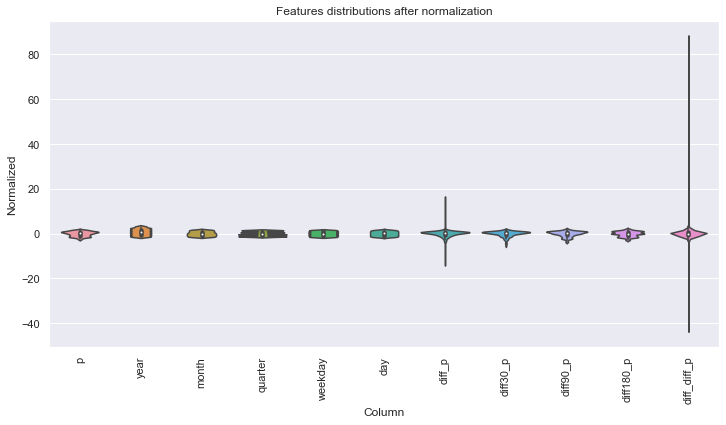

In [29]:
df_norm = (df - train_mean) / train_std
df_norm = df_norm.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_norm)
ax.set_xticklabels(df.keys(), rotation=90)
ax.set_title('Features distributions after normalization');

### Data windowing

In [30]:
# The horizon size
label_width = 93

# history_factor
h_factor = 1.25

# An history length of 
input_width = int(label_width * h_factor)

# Number of feature values to predict at once
shift = label_width

# batch size
batch_size = 64


window = WindowGenerator(input_width=input_width, 
                         label_width=label_width, 
                         shift=shift,
                         batch_size=batch_size,
                         train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['p'])

no_suffled_window = WindowGenerator(input_width=input_width, 
                         label_width=label_width, 
                         shift=shift,
                         batch_size=batch_size,
                         train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['p'], shuffle=False)
print(window)

Total window size: 209
History length: 116
Horizon length: 93
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115]
Label indices: [116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208]
Label column name(s): ['p']


In [31]:
def plot_forecast(model, name, label_index = None):
    last_history = np.expand_dims(test_df.tail(input_width).values, axis=0)
    
    forecast = model.predict(last_history).squeeze()
    
    if label_index is not None:
        forecast = forecast[:, label_index]
        
    forecast = forecast * train_std['p'] + train_mean['p']
    
    forecast_index = pd.date_range(start=test_df.index[-1], end=test_df.index[-1] + pd.Timedelta(label_width, unit='D'))[1:]

    series = df.p.append(pd.Series(data=forecast, index=forecast_index))

    series.plot(figsize=(20, 5), label='')
    plt.plot(forecast_index, forecast, label='forecast', lw=3)
    plt.legend()
    plt.title(name, fontsize=22)
    plt.show()

# Models

In [32]:
MAX_EPOCHS = 50
patience = 5

In [33]:
val_performance = {}
test_performance = {}
models = {}

## Model 

In [74]:
class RNForecaster(tf.keras.Model):
    def __init__(self, kernel_size, filters, label_width, n_blocks=2, use_batch_norm=False,**kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
        self.bn = use_batch_norm
        
        self.conv_init = tf.keras.layers.Conv1D(filters=filters, kernel_size=self.kernel_size, activation='relu', padding='same', name='conv_init')
        self.bn_init = tf.keras.layers.BatchNormalization(name='bn_init')
        
        self.convs = []
        self.bns = []
        self.adds = []
        
        for stage in range(n_blocks):
            conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=self.kernel_size, activation='relu', padding='same', name=f"conv_{stage}")
            self.convs.append(conv)
                
            bn = tf.keras.layers.BatchNormalization(name=f"bn_{stage}")
            self.bns.append(bn)
                
            self.adds.append(tf.keras.layers.Add(name=f'add_{stage}'))
                
                
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=label_width)
        self.reshape = tf.keras.layers.Reshape((label_width, -1))
        
    def call(self, inputs):
        out = self.conv_init(inputs)
        
        if self.bn:
            out = self.bn_init(out)
            
        for i in range(len(self.convs)):
            out_shortcut = out
            out = self.convs[i](out)
            out = self.bns[i](out)
            out = self.adds[i]([out, out_shortcut])
        
        out = self.flatten(out)
        
        out = self.dropout(out)
        out = self.dense1(out)        
        out = self.dense2(out)
        out = self.reshape(out)
        
        return out
    
    def build_graph(self, input_shape):
        x = tf.keras.layers.Input(shape=(input_shape))
        return tf.keras.models.Model(inputs=[x], outputs=self.call(x))


In [75]:
conv_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='conv2')

In [76]:
CONV_WIDTH = 3
filters = 64
n_blocks = 2
use_bn = True

rnForecaster = RNForecaster(kernel_size=CONV_WIDTH, label_width=label_width, filters=filters, n_blocks=n_blocks, use_batch_norm=use_bn)

history = compile_and_fit(rnForecaster, window, patience=patience, epochs=MAX_EPOCHS)

val_performance['rnForecaster V0'] = rnForecaster.evaluate(window.val)
test_performance['rnForecaster V0'] = rnForecaster.evaluate(window.test, verbose=0)
models['rnForecaster'] = rnForecaster

Epoch 1/50
23/23 [==============================] - 2s 47ms/step - loss: 3.0991 - val_loss: 1.6917
Epoch 2/50
23/23 [==============================] - 1s 40ms/step - loss: 0.7007 - val_loss: 1.5637
Epoch 3/50
23/23 [==============================] - 1s 44ms/step - loss: 0.2886 - val_loss: 1.5978
Epoch 4/50
23/23 [==============================] - 1s 47ms/step - loss: 0.1971 - val_loss: 1.6854
Epoch 5/50
23/23 [==============================] - 1s 41ms/step - loss: 0.1496 - val_loss: 1.5787
Epoch 6/50
23/23 [==============================] - 1s 41ms/step - loss: 0.1175 - val_loss: 1.5970
Epoch 7/50
5/5 [==============================] - 0s 6ms/step - loss: 1.5637


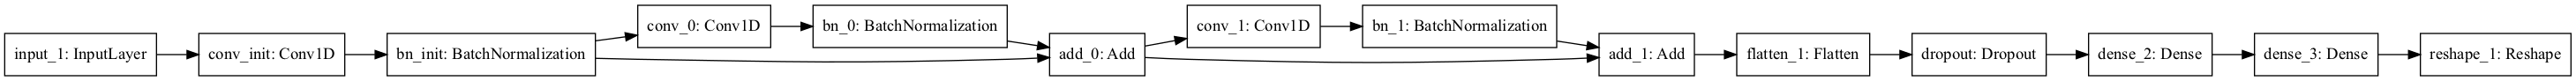

In [77]:
tf.keras.utils.plot_model(rnForecaster.build_graph(window.val.element_spec[0].shape[1:]), 'Images/RNForecaster.png', rankdir='LR')

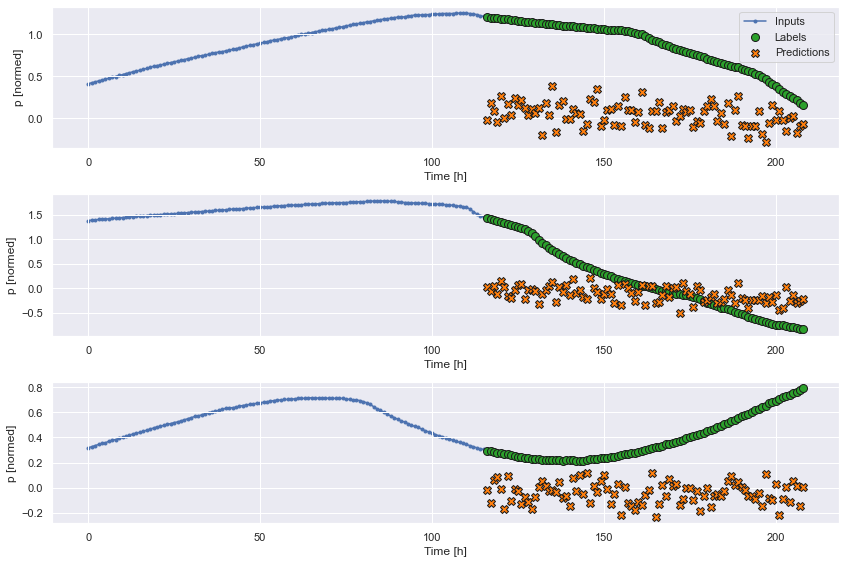

In [79]:
window.plot(rnForecaster, plot_col='p')

In [80]:
conv_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='conv2')

history = compile_and_fit(conv_model2, window, patience=patience, epochs=MAX_EPOCHS)

val_performance['Conv2'] = conv_model2.evaluate(window.val)
test_performance['Conv2'] = conv_model2.evaluate(window.test, verbose=0)
models['conv2'] = conv_model2

Epoch 1/50
23/23 [==============================] - 1s 45ms/step - loss: 0.4432 - val_loss: 1.0807
Epoch 2/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0457 - val_loss: 1.1017
Epoch 3/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0137 - val_loss: 1.0758
Epoch 4/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0074 - val_loss: 1.1080
Epoch 5/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0052 - val_loss: 1.0962
Epoch 6/50
23/23 [==============================] - 1s 40ms/step - loss: 0.0039 - val_loss: 1.0962
Epoch 7/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0033 - val_loss: 1.0955
Epoch 8/50
5/5 [==============================] - 0s 8ms/step - loss: 1.0758


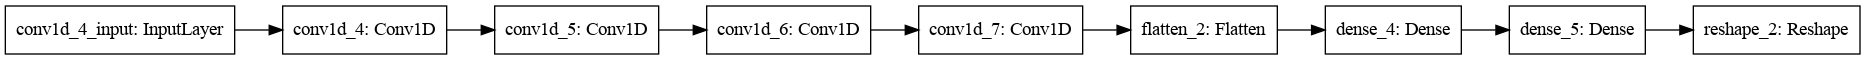

In [38]:
tf.keras.utils.plot_model(conv_model2, 'Images/Conv2.png', rankdir='LR')

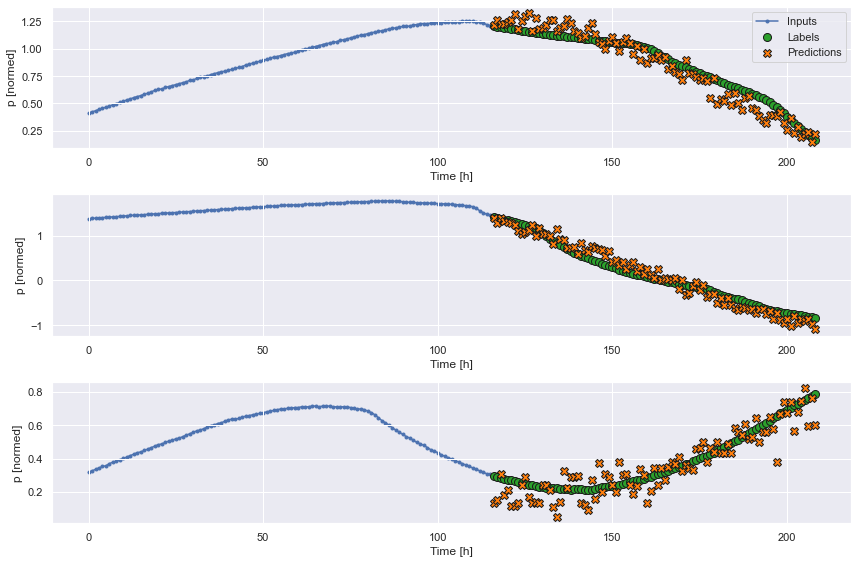

In [81]:
window.plot(conv_model2, plot_col='p')

In [82]:
conv_model3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.AveragePooling1D(3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='conv3')

history = compile_and_fit(conv_model3, window, patience=patience, epochs=MAX_EPOCHS)

val_performance['Conv3'] = conv_model3.evaluate(window.val)
test_performance['Conv3'] = conv_model3.evaluate(window.test, verbose=0)
models['conv3'] = conv_model3

Epoch 1/50
23/23 [==============================] - 1s 25ms/step - loss: 0.7007 - val_loss: 1.9680
Epoch 2/50
23/23 [==============================] - 0s 20ms/step - loss: 0.2181 - val_loss: 1.6362
Epoch 3/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0471 - val_loss: 1.5600
Epoch 4/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0206 - val_loss: 1.4035
Epoch 5/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0129 - val_loss: 1.3861
Epoch 6/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0103 - val_loss: 1.4257
Epoch 7/50
23/23 [==============================] - 0s 20ms/step - loss: 0.0080 - val_loss: 1.4070
Epoch 8/50
23/23 [==============================] - 1s 21ms/step - loss: 0.0063 - val_loss: 1.3823
Epoch 9/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0053 - val_loss: 1.4221
Epoch 10/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0047 - val_loss: 1.3928
Epoch 11/

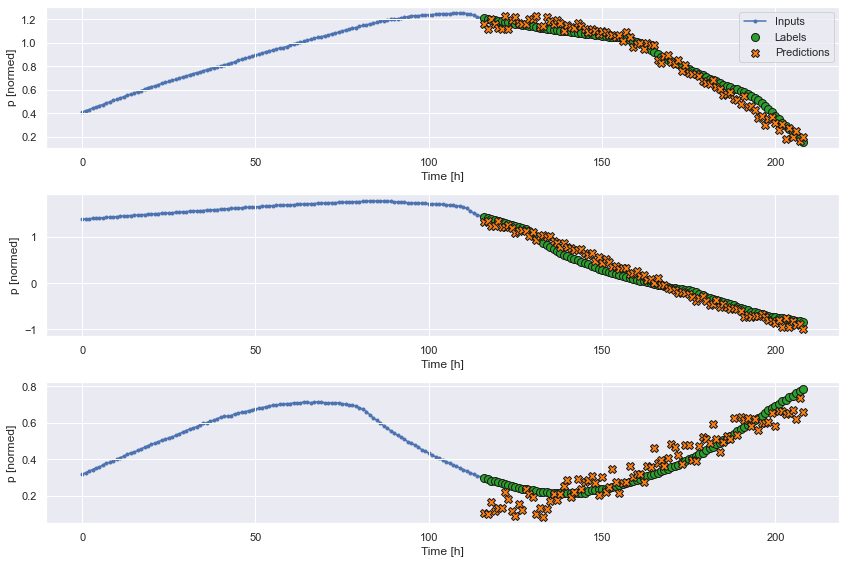

In [83]:
window.plot(conv_model3, plot_col='p')

In [85]:
conv_model4 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='conv4')

history = compile_and_fit(conv_model4, window, patience=patience, epochs=MAX_EPOCHS)

val_performance['Conv4'] = conv_model4.evaluate(window.val)
test_performance['Conv4'] = conv_model4.evaluate(window.test, verbose=0)
models['conv4'] = conv_model4

Epoch 1/50
23/23 [==============================] - 3s 90ms/step - loss: 0.7335 - val_loss: 1.9329
Epoch 2/50
23/23 [==============================] - 2s 89ms/step - loss: 0.3860 - val_loss: 1.4915
Epoch 3/50
23/23 [==============================] - 2s 86ms/step - loss: 0.1563 - val_loss: 1.2240
Epoch 4/50
23/23 [==============================] - 2s 86ms/step - loss: 0.0545 - val_loss: 0.9522
Epoch 5/50
23/23 [==============================] - 2s 87ms/step - loss: 0.0169 - val_loss: 1.0523
Epoch 6/50
23/23 [==============================] - 2s 87ms/step - loss: 0.0134 - val_loss: 0.9607
Epoch 7/50
23/23 [==============================] - 2s 86ms/step - loss: 0.0089 - val_loss: 1.0283
Epoch 8/50
23/23 [==============================] - 2s 87ms/step - loss: 0.0052 - val_loss: 1.0853
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 0.9522


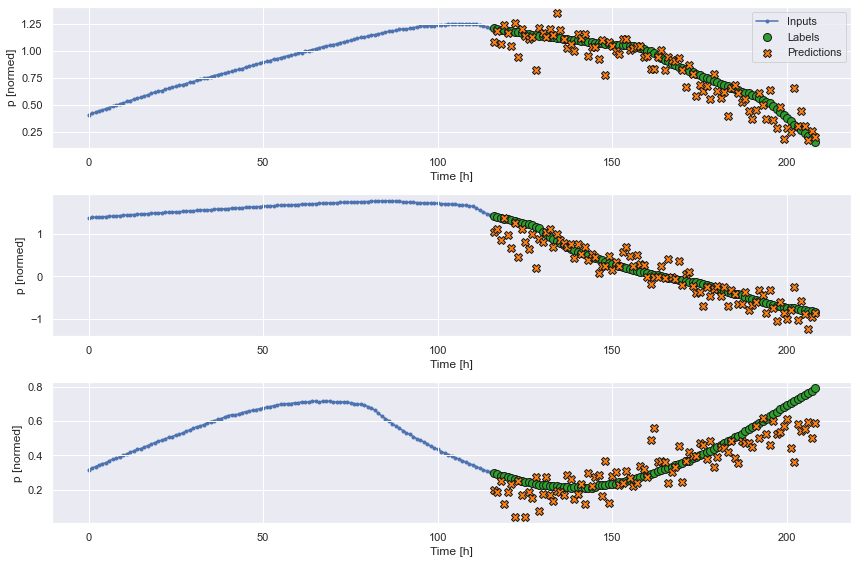

In [86]:
window.plot(conv_model4, plot_col='p')

In [ ]:
tf.keras.metrics.Me

In [87]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(units=label_width),
    tf.keras.layers.Reshape((label_width, -1))
], name='lstm2')

history = compile_and_fit(lstm_model2, no_suffled_window, patience=patience, epochs=MAX_EPOCHS)

val_performance['LSTM 2'] = lstm_model2.evaluate(window.val)
test_performance['LSTM 2'] = lstm_model2.evaluate(window.test, verbose=0)
models['LSTM 2'] = lstm_model2

Epoch 1/50
23/23 [==============================] - 5s 114ms/step - loss: 0.8193 - val_loss: 1.8987
Epoch 2/50
23/23 [==============================] - 2s 93ms/step - loss: 0.5398 - val_loss: 2.0991
Epoch 3/50
23/23 [==============================] - 2s 95ms/step - loss: 0.3641 - val_loss: 1.6779
Epoch 4/50
23/23 [==============================] - 2s 98ms/step - loss: 0.2441 - val_loss: 1.6170
Epoch 5/50
23/23 [==============================] - 2s 102ms/step - loss: 0.1845 - val_loss: 0.9613
Epoch 6/50
23/23 [==============================] - 2s 98ms/step - loss: 0.1610 - val_loss: 1.4415
Epoch 7/50
23/23 [==============================] - 2s 95ms/step - loss: 0.1641 - val_loss: 1.3885
Epoch 8/50
23/23 [==============================] - 2s 99ms/step - loss: 0.1848 - val_loss: 1.3205
Epoch 9/50
23/23 [==============================] - 2s 94ms/step - loss: 0.1491 - val_loss: 1.3321
Epoch 10/50
5/5 [==============================] - 0s 25ms/step - loss: 0.9613


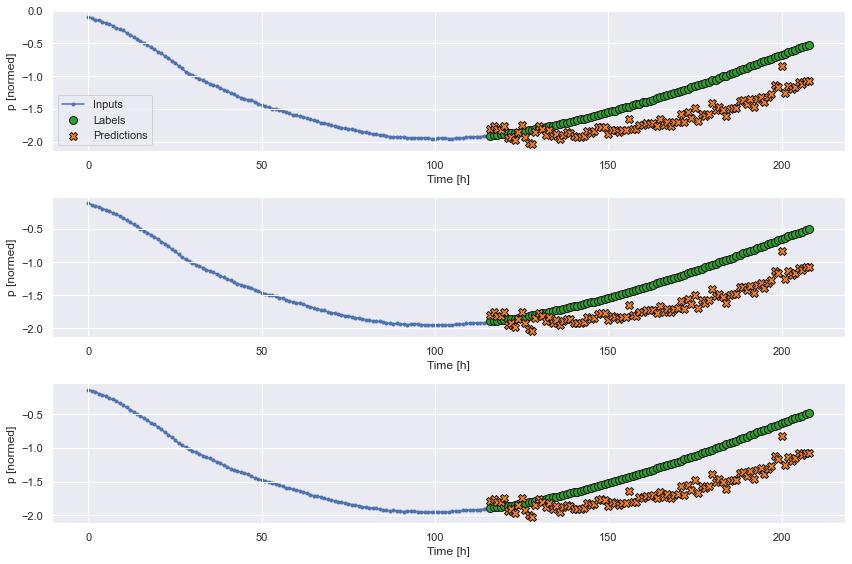

In [88]:
no_suffled_window.plot(lstm_model2, plot_col='p')

In [89]:
df_results = pd.DataFrame({'val_loss': val_performance, 'test_loss': test_performance})
df_results

,val_loss,test_loss
rnForecaster V0,1.563663,0.620634
Conv2,1.075757,0.347803
Conv3,1.382342,0.873782
Conv4,0.952205,0.480271
LSTM 2,0.961316,0.490118


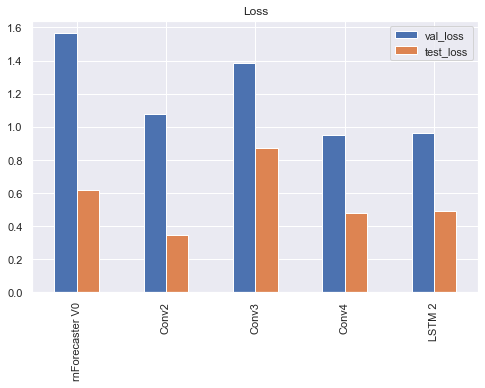

In [90]:
df_results.plot(kind='bar', title='Loss', figsize=(8, 5));

## Ploting forecasts

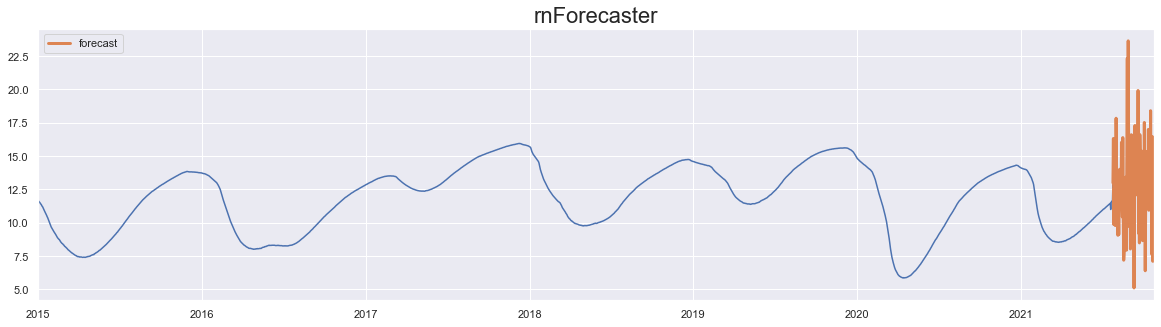

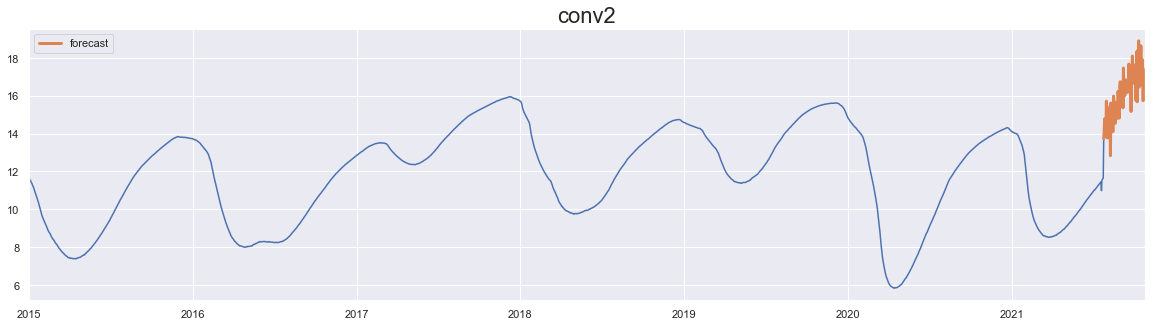

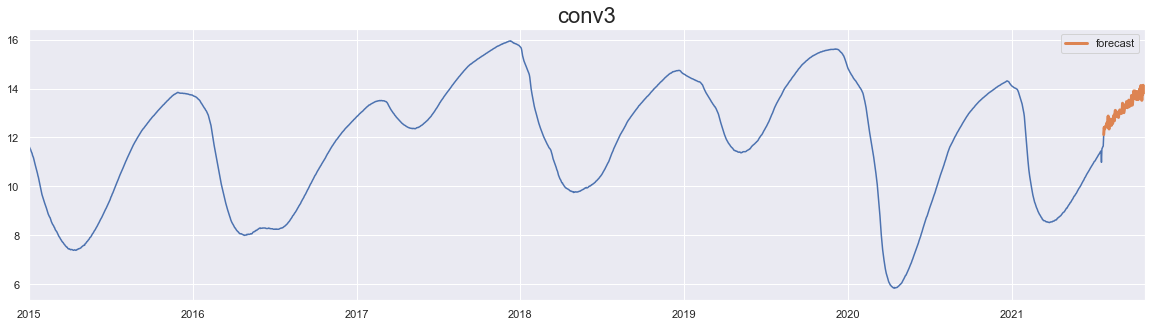

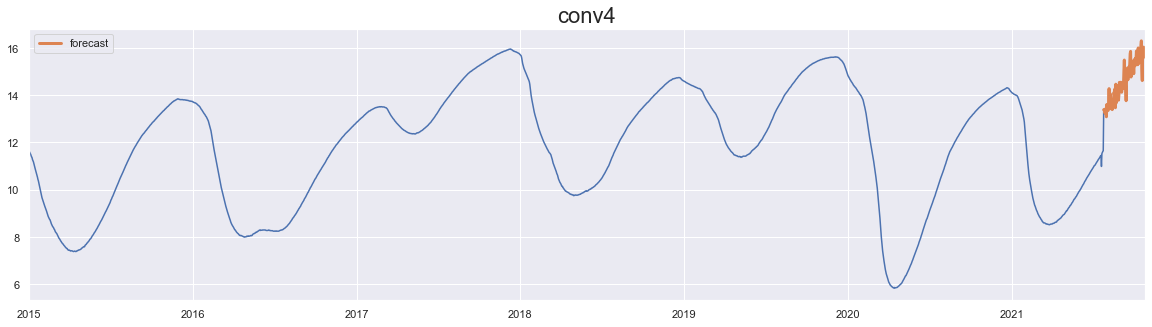

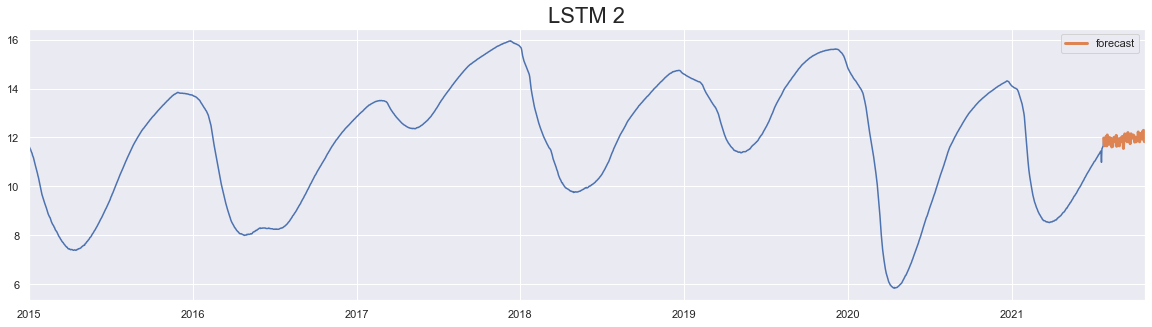

In [93]:
for name, model in models.items():
    label_index = window.column_indices['p'] if 'AR' in name else None
    plot_forecast(model, name, label_index=label_index)

# Trying other models